In [1]:
import sqlite3
import pandas as pd

# Membuat koneksi database SQLite di Google Colab
conn = sqlite3.connect('perpustakaan.db')
cursor = conn.cursor()

# 1. Membuat tabel buku
cursor.execute('''
CREATE TABLE IF NOT EXISTS buku (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    judul TEXT,
    penulis TEXT,
    tahun INTEGER
)
''')

# 2. Membuat tabel anggota
cursor.execute('''
CREATE TABLE IF NOT EXISTS anggota (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    nama TEXT,
    email TEXT
)
''')

# 3. Membuat tabel peminjaman
cursor.execute('''
CREATE TABLE IF NOT EXISTS peminjaman (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    id_anggota INTEGER,
    id_buku INTEGER,
    tgl_pinjam DATE,
    tgl_kembali DATE,
    FOREIGN KEY (id_anggota) REFERENCES anggota (id),
    FOREIGN KEY (id_buku) REFERENCES buku (id)
)
''')

conn.commit()
print("✅ Tabel berhasil dibuat.")


✅ Tabel berhasil dibuat.


In [2]:
# a. Tambahkan data buku
data_buku = [
    ('Laskar Pelangi', 'Andrea Hirata', 2005),
    ('Bumi Manusia', 'Pramoedya Ananta Toer', 1980),
    ('Negeri 5 Menara', 'Ahmad Fuadi', 2009),
    ('Dilan 1990', 'Pidi Baiq', 2014),
    ('Cantik Itu Luka', 'Eka Kurniawan', 2002)
]
cursor.executemany("INSERT INTO buku (judul, penulis, tahun) VALUES (?, ?, ?)", data_buku)

# Tambahkan data anggota
data_anggota = [
    ('Nisa Aulia', 'nisa@example.com'),
    ('Dewi Lestari', 'dewi@example.com'),
    ('Budi Santoso', 'budi@example.com')
]
cursor.executemany("INSERT INTO anggota (nama, email) VALUES (?, ?)", data_anggota)

conn.commit()
print("✅ Data buku & anggota berhasil ditambahkan.")


✅ Data buku & anggota berhasil ditambahkan.


In [3]:
data_peminjaman = [
    (1, 1, '2025-11-01', '2025-11-05'),  # Nisa pinjam Laskar Pelangi
    (2, 2, '2025-11-02', '2025-11-08'),  # Dewi pinjam Bumi Manusia
    (3, 3, '2025-11-03', None),          # Budi pinjam Negeri 5 Menara (belum kembali)
    (1, 4, '2025-11-04', '2025-11-09')   # Nisa pinjam Dilan 1990
]
cursor.executemany("INSERT INTO peminjaman (id_anggota, id_buku, tgl_pinjam, tgl_kembali) VALUES (?, ?, ?, ?)", data_peminjaman)

conn.commit()
print("✅ Data peminjaman berhasil ditambahkan.")


✅ Data peminjaman berhasil ditambahkan.


In [5]:
query_join = '''
SELECT
    p.id,
    a.nama AS nama_anggota,
    b.judul AS judul_buku,
    p.tgl_pinjam,
    p.tgl_kembali
FROM peminjaman p
JOIN anggota a ON p.id_anggota = a.id
JOIN buku b ON p.id_buku = b.id
'''
df_peminjaman = pd.read_sql_query(query_join, conn)
df_peminjaman



,id,nama_anggota,judul_buku,tgl_pinjam,tgl_kembali
0,1,Nisa Aulia,Laskar Pelangi,2025-11-01,2025-11-05
1,2,Dewi Lestari,Bumi Manusia,2025-11-02,2025-11-08
2,3,Budi Santoso,Negeri 5 Menara,2025-11-03,None
3,4,Nisa Aulia,Dilan 1990,2025-11-04,2025-11-09


In [6]:
query_group = '''
SELECT
    a.nama AS nama_anggota,
    COUNT(p.id_buku) AS jumlah_buku_dipinjam
FROM peminjaman p
JOIN anggota a ON p.id_anggota = a.id
GROUP BY a.nama
'''
df_jumlah = pd.read_sql_query(query_group, conn)
df_jumlah


,nama_anggota,jumlah_buku_dipinjam
0,Budi Santoso,1
1,Dewi Lestari,1
2,Nisa Aulia,2


In [7]:
# Pastikan tgl_pinjam & tgl_kembali bertipe datetime
df_peminjaman['tgl_pinjam'] = pd.to_datetime(df_peminjaman['tgl_pinjam'])
df_peminjaman['tgl_kembali'] = pd.to_datetime(df_peminjaman['tgl_kembali'])

# Hitung durasi peminjaman (hari)
df_peminjaman['durasi_pinjam'] = (df_peminjaman['tgl_kembali'] - df_peminjaman['tgl_pinjam']).dt.days

df_peminjaman


,id,nama_anggota,judul_buku,tgl_pinjam,tgl_kembali,durasi_pinjam
0,1,Nisa Aulia,Laskar Pelangi,2025-11-01,2025-11-05,4.0
1,2,Dewi Lestari,Bumi Manusia,2025-11-02,2025-11-08,6.0
2,3,Budi Santoso,Negeri 5 Menara,2025-11-03,NaT,NaN
3,4,Nisa Aulia,Dilan 1990,2025-11-04,2025-11-09,5.0


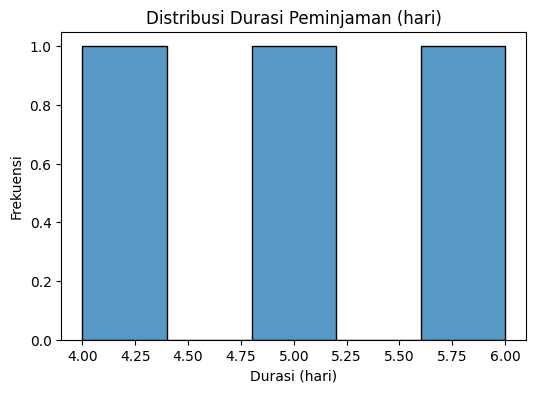

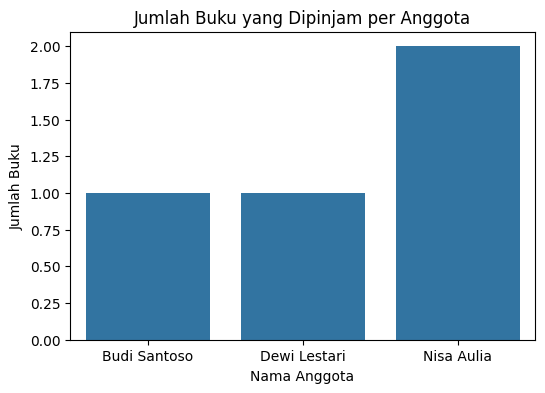

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram durasi peminjaman
plt.figure(figsize=(6,4))
sns.histplot(df_peminjaman['durasi_pinjam'].dropna(), bins=5)
plt.title('Distribusi Durasi Peminjaman (hari)')
plt.xlabel('Durasi (hari)')
plt.ylabel('Frekuensi')
plt.show()






# Diagram batang jumlah buku per anggota
plt.figure(figsize=(6,4))
sns.barplot(data=df_jumlah, x='nama_anggota', y='jumlah_buku_dipinjam')
plt.title('Jumlah Buku yang Dipinjam per Anggota')
plt.xlabel('Nama Anggota')
plt.ylabel('Jumlah Buku')
plt.show()
